In [40]:
import argparse
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from mlp_numpy import MLP  
from modules import CrossEntropy

# Default constants
DNN_HIDDEN_UNITS_DEFAULT = 20
LEARNING_RATE_DEFAULT = 1e-2
MAX_EPOCHS_DEFAULT = 1500 # adjust if you use batch or not
EVAL_FREQ_DEFAULT = 10

def accuracy(predictions, targets):
    pred = np.argmax(predictions, axis=1)
    true_classes = np.argmax(targets, axis=1)
    return np.mean(pred == true_classes)

def shuffle_and_batch(X, y, batch_size):
    shuffle_index = np.random.permutation(len(X))
    X_shuffled = X[shuffle_index]
    y_shuffled = y[shuffle_index]
    
    num_batches = len(X) // batch_size
    batches = []
    
    for i in range(num_batches):
        X_batch = X_shuffled[i * batch_size:(i + 1) * batch_size]
        y_batch = y_shuffled[i * batch_size:(i + 1) * batch_size]
        batches.append((X_batch, y_batch))
    
    if len(X) % batch_size != 0:
        X_batch = X_shuffled[num_batches * batch_size:]
        y_batch = y_shuffled[num_batches * batch_size:]
        batches.append((X_batch, y_batch))
    
    return batches


In [45]:
def train(dnn_hidden_units, learning_rate, max_steps, eval_freq, sgd=False, batch_size=1):
    X, y = make_moons(n_samples=1000, shuffle=True)
    n_values = np.max(y) + 1
    y = np.eye(n_values)[y]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    steps, acc_train, acc_test, loss_train, loss_test = [], [], [], [], []

    model = MLP(n_inputs=2, n_hidden=[20], n_classes=2)
    loss = CrossEntropy()
    
    for step in range(max_steps):
        if not sgd:
            y = model.forward(X_train)
            l = loss.forward(y, y_train)
            dout = loss.backward(y, y_train)
            model.backward(dout)
            model.head.params['weight'] = model.head.params['weight'] - learning_rate * model.head.grads['weight']
            model.head.params['bias'] = model.head.params['bias'] - learning_rate * model.head.grads['bias']
            for linear in model.linears:
                linear.params['weight'] = linear.params['weight'] - learning_rate * linear.grads['weight']
                linear.params['bias'] = linear.params['bias'] - learning_rate * linear.grads['bias']
        elif sgd:
            batches = shuffle_and_batch(X_train, y_train, batch_size=batch_size)
            for X, y in batches:
                y_hat = model.forward(X)
                l = loss.forward(y_hat, y)
                dout = loss.backward(y_hat, y)
                model.backward(dout)
                model.head.params['weight'] = model.head.params['weight'] - learning_rate * model.head.grads['weight']
                model.head.params['bias'] = model.head.params['bias'] - learning_rate * model.head.grads['bias']
                for linear in model.linears:
                    linear.params['weight'] = linear.params['weight'] - learning_rate * linear.grads['weight']
                    linear.params['bias'] = linear.params['bias'] - learning_rate * linear.grads['bias']

        if step % eval_freq == 0 or step == max_steps - 1:
            y = model.forward(X_train)
            l = loss.forward(y, y_train)
            steps.append(step)
            acc_train.append(accuracy(y, y_train))
            loss_train.append(l)
            y = model.forward(X_test)
            acc_test.append(accuracy(y, y_test))
            loss_test.append(l)
            print(f"Step: {step}, Loss: {l}, Accuracy: {accuracy(y, y_test)}")
    
    print("Training complete!")
    return steps, acc_train, acc_test, loss_train, loss_test

In [35]:
steps, acc_train, acc_test, loss_train, loss_test = \
    train(DNN_HIDDEN_UNITS_DEFAULT, LEARNING_RATE_DEFAULT, MAX_EPOCHS_DEFAULT, EVAL_FREQ_DEFAULT)

Step: 0, Loss: 0.6931471041012471, Accuracy: 0.475
Step: 10, Loss: 1.7797829099857208, Accuracy: 0.475
Step: 20, Loss: 0.6313705638468794, Accuracy: 0.725
Step: 30, Loss: 1.9720445972815366, Accuracy: 0.75
Step: 40, Loss: 0.41538488517691063, Accuracy: 0.785
Step: 50, Loss: 0.3621855977563946, Accuracy: 0.81
Step: 60, Loss: 0.3909846840504298, Accuracy: 0.81
Step: 70, Loss: 0.3616993719776772, Accuracy: 0.81
Step: 80, Loss: 0.34052742796816665, Accuracy: 0.805
Step: 90, Loss: 0.33135420559609297, Accuracy: 0.81
Step: 100, Loss: 0.321134796479773, Accuracy: 0.815
Step: 110, Loss: 0.3157771204866865, Accuracy: 0.82
Step: 120, Loss: 0.31472276125886905, Accuracy: 0.825
Step: 130, Loss: 0.3179354949212205, Accuracy: 0.825
Step: 140, Loss: 0.3538517107341122, Accuracy: 0.815
Step: 150, Loss: 0.3474774231578195, Accuracy: 0.815
Step: 160, Loss: 0.34752230297518966, Accuracy: 0.815
Step: 170, Loss: 0.34772178573074614, Accuracy: 0.815
Step: 180, Loss: 0.3477153646011591, Accuracy: 0.815
Step:

In [51]:
# With sgd
steps, acc_train, acc_test, loss_train, loss_test = \
    train(DNN_HIDDEN_UNITS_DEFAULT, LEARNING_RATE_DEFAULT, MAX_EPOCHS_DEFAULT, EVAL_FREQ_DEFAULT, True, batch_size=200)

Step: 0, Loss: 0.6964458445784348, Accuracy: 0.505
Step: 10, Loss: 0.2568882188611425, Accuracy: 0.875
Step: 20, Loss: 0.2186593755120207, Accuracy: 0.885
Step: 30, Loss: 0.13409199109000858, Accuracy: 0.94
Step: 40, Loss: 0.03805209937022698, Accuracy: 1.0
Step: 50, Loss: 0.014506653821931583, Accuracy: 1.0
Step: 60, Loss: 0.008100060978082113, Accuracy: 1.0
Step: 70, Loss: 0.005412722036905293, Accuracy: 1.0
Step: 80, Loss: 0.003986674138592504, Accuracy: 1.0
Step: 90, Loss: 0.003115651014857648, Accuracy: 1.0
Step: 100, Loss: 0.0025371007882992315, Accuracy: 1.0
Step: 110, Loss: 0.0021288058562213634, Accuracy: 1.0
Step: 120, Loss: 0.0018265446578512548, Accuracy: 1.0
Step: 130, Loss: 0.0015943036553732867, Accuracy: 1.0
Step: 140, Loss: 0.001411343866306625, Accuracy: 1.0
Step: 150, Loss: 0.001263554275160319, Accuracy: 1.0
Step: 160, Loss: 0.0011418512905257757, Accuracy: 1.0
Step: 170, Loss: 0.0010404086896497518, Accuracy: 1.0
Step: 180, Loss: 0.0009543819853922096, Accuracy: 1.

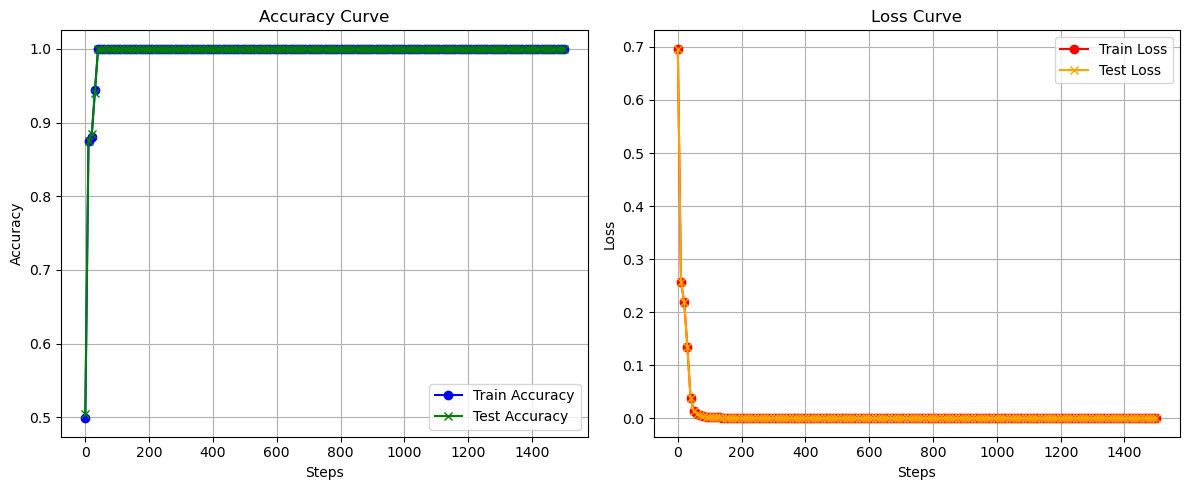

In [52]:
import matplotlib.pyplot as plt

def plot_training_curves(steps, acc_train, acc_test, loss_train, loss_test):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(steps, acc_train, label='Train Accuracy', color='b', marker='o')
    ax[0].plot(steps, acc_test, label='Test Accuracy', color='g', marker='x')
    ax[0].set_title('Accuracy Curve')
    ax[0].set_xlabel('Steps')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(steps, loss_train, label='Train Loss', color='r', marker='o')
    ax[1].plot(steps, loss_test, label='Test Loss', color='orange', marker='x')
    ax[1].set_title('Loss Curve')
    ax[1].set_xlabel('Steps')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    
    plt.show()

plot_training_curves(steps, acc_train, acc_test, loss_train, loss_test)